## Gaussian process regression on faces dataset ##

Importing necessary packages

In [3]:
import numpy as np
from scipy import spatial, optimize
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
import matplotlib.pylab as plt
import vtk
import vtkplotlib as vpl
from vtk.util.numpy_support import vtk_to_numpy
import os
from scipy import spatial
from sklearn.decomposition import PCA

Defining preprocessing and visualization functions

In [4]:
def readfile(filename):
    reader = vtk.vtkGenericDataObjectReader()
    reader.SetFileName(filename)
    reader.Update()

    polydata = reader.GetOutput()

    points = polydata.GetPoints()
    array = points.GetData()
    numpy_nodes = vtk_to_numpy(array)
    #print(numpy_nodes)
    cells = polydata.GetPolys()
    nCells = cells.GetNumberOfCells()
    array = cells.GetData()
    # This holds true if all polys are of the same kind, e.g. triangles.
    assert(array.GetNumberOfValues()%nCells==0)
    nCols = array.GetNumberOfValues()//nCells
    numpy_cells = vtk_to_numpy(array)
    numpy_cells = numpy_cells.reshape((-1,nCols))
    return numpy_cells, numpy_nodes

def write_vtk(points, cell, filename):
    with open(filename, 'w') as f:
        # Write header
        f.write("# vtk DataFile Version 4.2\n")
        f.write("vtk output\n")
        f.write("ASCII\n")
        f.write("DATASET POLYDATA\n")
        
        # Write points
        num_points = len(points)
        f.write("POINTS {} float\n".format(num_points))
        for point in points:
            f.write("{} {} {}\n".format(point[0], point[1], point[2]))
        
        # Write cells
        num_cells = len(cell)
        total_num_points = np.sum(cell[:, 0])
        f.write("POLYGONS {} {}\n".format(num_cells, total_num_points + num_cells))
        for cell_indices in cell:
            num_indices = cell_indices[0]
            f.write("{} ".format(num_indices))
            for index in cell_indices[1:]:
                f.write("{} ".format(index))
            f.write("\n")

def visualize(nameOfFile):

        # Load the VTK file
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(nameOfFile)
    reader.Update()

    # Create a mapper
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(reader.GetOutputPort())

    # Create an actor
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)

    # Create a renderer and add the actor to it
    renderer = vtk.vtkRenderer()
    renderer.AddActor(actor)

    # Create a render window and set the renderer as its active renderer
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(600, 600)
    renderer.ResetCamera()

    # Create an interactor and start the visualization
    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(renderWindow)
    interactor.Start()

def unmake_xy(hand):
    return np.vstack([hand[range(0, len(hand), 3)], hand[range(1, len(hand), 3)], hand[range(2, len(hand), 3)]]).T

def make_xy(hand) :
    return hand.flatten()

def My_Visualize(Faces_List=[], Wiring=[], colors=[], Scatter=[0]):
    mesh = Faces_List[0][Wiring][:, 1:]
    offset = np.zeros(mesh.shape)
    vpl.figure("Face")
    for i in range(len(Faces_List)) :
        mesh = Faces_List[i][Wiring][:, 1:] + offset
        vpl.mesh_plot(mesh, color=colors[i])
        offset[:, :, 0] += 0.01
    if Scatter[0]:
        vpl.scatter(Faces_List[0][Scatter], radius=0.0001, color='r')
    vpl.show()

Defining gaussian process regressors class

In [5]:
class GPregressor :
    def __init__(self, Input_dim, Nb_points, kernel):
        self.dim_i = Input_dim
        self.Nb = Nb_points
        self.kernel = kernel
        self.Cov_mat = []

    def unmake_xy(self, hand):
        return np.vstack([hand[range(0, len(hand), 3)], hand[range(1, len(hand), 3)], hand[range(2, len(hand), 3)]]).T

    def make_xy(self, hand) :
        return hand.flatten()

    def Cov_func(self, Points):
        #kernel = 1.0 * Matern(length_scale=l, nu=n)+ ConstantKernel()+ WhiteKernel(noise_level=0.001)
        return self.kernel(Points)

    def fit(self, Training_shapes) :

        Reduced_cov = np.zeros((self.Nb, self.Nb))
        for i in range(len(Training_shapes)) :
            Reduced_cov += self.Cov_func(self.unmake_xy(Training_shapes[i, :]))

        Reduced_cov /= len(Training_shapes)

        Cov_matrix = np.zeros((self.dim_i*Reduced_cov.shape[0], self.dim_i*Reduced_cov.shape[0]))
        for i in range(self.Nb):
            for j in range(self.Nb) :
                Cov_matrix[self.dim_i*i:self.dim_i*(i+1), self.dim_i*j:self.dim_i*(j+1)] = Reduced_cov[i, j]*np.eye(self.dim_i)
        
        self.Cov_mat = Cov_matrix

    def predict(self, Incomplete_shape, Indexes) :
        observed_points = Incomplete_shape[Indexes==1]
        Kxy = self.Cov_mat[Indexes==0, :][:, Indexes==1]
        Kyy = self.Cov_mat[Indexes==1, :][:, Indexes==1]

        Predicted_points = Kxy@np.linalg.inv(Kyy)@observed_points

        Zipped_data = np.zeros(Incomplete_shape.shape)
        Zipped_data[Indexes==0] = Predicted_points
        Zipped_data[Indexes==1] = observed_points

        return Zipped_data

Reading and preprocessing (Aligning) the data

In [6]:
## Reading the shapes already aligned (using proscrutes) and stored in Aligned_data folder 
path = '../../Aligned_data/'

L = os.listdir(path)
Dataset = []
Wiring = []

for f in L :
    if 'vtk' in f :
       Tab, Tob = readfile(path+f)
       Dataset.append(make_xy(Tob))
       Wiring.append(Tab)
    #My_Visualize([Tob], Tab, ['w'])
Dataset = np.array(Dataset[:-1])
Dataset.shape

(10, 159447)

Marking the missing region

In [7]:
def Region(T, center, radius):
    Indexes = []
    for i in range(len(T)) :
        if np.linalg.norm(T[i]-center)<radius :
            Indexes.append(i)
    return Indexes

Indexes = []
Tob = unmake_xy(Dataset[0, :])
Indexes = Region(Tob, [0.0005, 0.0012, 0.004], 0.00135)
print(len(Indexes))
My_Visualize([Tob], Tab, ['w'], Indexes)

854


In [8]:
from copy import deepcopy

N_process = 18

Decoding = []

for j in range(N_process) :
    L = []
    for i in range(0, Dataset.shape[1], 3) :
        if (i//3)%N_process == j :
            L.append(i)
            L.append(i+1)
            L.append(i+2)
    Decoding.append(L)

print(len(Decoding))
    
Regions_decod = deepcopy(Decoding)

for i in range(len(Regions_decod)) :
    for j in range(len(Regions_decod[i])) :
        if (Decoding[i][j]//3 in Indexes) :
            Regions_decod[i][j] = 0 
        else :
            Regions_decod[i][j] = 1

18


In [9]:
Mean_shape = np.mean(Dataset, axis=0)
Dataset /= np.max(Dataset)
Dataset = Dataset - Mean_shape
Mean_shape.shape

(159447,)

Augmenting the data 

In [10]:
Train_data = Dataset[:9, :]
Test_data = Dataset[9, :]

Train_data.shape, Test_data.shape

((9, 159447), (159447,))

In [11]:
pca = PCA(n_components=3)
pca.fit(Train_data)

Y = pca.fit_transform(Train_data)

In [12]:
m1, M1 = min(Y[:, 0]), max(Y[:, 0])
m2, M2 = min(Y[:, 1]), max(Y[:, 1])
m3, M3 = min(Y[:, 2]), max(Y[:, 2])

M = max(abs(np.array([m1, M1, m2, M2, m3, M3])))
New_samples = np.random.uniform(-M, M, (11, 3))

New_shapes = pca.inverse_transform(New_samples)
New_shapes.shape

(11, 159447)

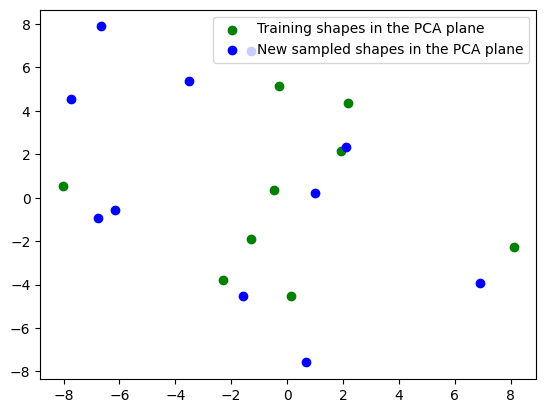

In [13]:
plt.scatter(Y[:, 0], Y[:, 1], label="Training shapes in the PCA plane", c='g')
plt.scatter(New_samples[:, 0], New_samples[:, 1], label="New sampled shapes in the PCA plane", c='b')
plt.legend()
plt.show()

In [14]:
# Adding the new generated shapes to the dataset

Train_data = np.concatenate((Train_data, New_shapes), axis=0)

In [15]:
Train_data.shape, Mean_shape.shape
#My_Visualize([unmake_xy(Train_data[19, :]+Mean_shape)], Wiring[0],['w'])

((20, 159447), (159447,))

In [19]:
GP_net = []
params = [3, 1.5]
sigma = 0.001

for i in range(N_process) :
    print("Gaussian Process "+str(i+1)+" started training")
    My_kernel = 1.0 * Matern(length_scale=params[0], nu=params[1])+ ConstantKernel()+ WhiteKernel(noise_level=sigma)
    GP = GPregressor(Input_dim=3, Nb_points=len(Decoding[i])//3, kernel=My_kernel)
    GP.fit(Train_data[:, Decoding[i]])
    GP_net.append(GP)
    print(GP.Cov_mat[:10, :10])

Gaussian Process 1 started training
[[2.001      0.         0.         1.99982117 0.         0.
  1.99910247 0.         0.         1.9977298 ]
 [0.         2.001      0.         0.         1.99982117 0.
  0.         1.99910247 0.         0.        ]
 [0.         0.         2.001      0.         0.         1.99982117
  0.         0.         1.99910247 0.        ]
 [1.99982117 0.         0.         2.001      0.         0.
  1.99971233 0.         0.         1.99877329]
 [0.         1.99982117 0.         0.         2.001      0.
  0.         1.99971233 0.         0.        ]
 [0.         0.         1.99982117 0.         0.         2.001
  0.         0.         1.99971233 0.        ]
 [1.99910247 0.         0.         1.99971233 0.         0.
  2.001      0.         0.         1.99965393]
 [0.         1.99910247 0.         0.         1.99971233 0.
  0.         2.001      0.         0.        ]
 [0.         0.         1.99910247 0.         0.         1.99971233
  0.         0.         2.001

In [20]:
Test_shape = deepcopy(Test_data)

Predicted_shape = np.zeros(Test_shape.shape)

for i in range(N_process) :
    print("GP " + str(i)+" is processing the missing points")
    Test_shape_i = Test_shape[Decoding[i]]
    Predicted_points = GP_net[i].predict(Test_shape_i, np.array(Regions_decod[i]))
    Predicted_shape[Decoding[i]] = Predicted_points

GP 0 is processing the missing points
GP 1 is processing the missing points
GP 2 is processing the missing points
GP 3 is processing the missing points
GP 4 is processing the missing points
GP 5 is processing the missing points
GP 6 is processing the missing points
GP 7 is processing the missing points
GP 8 is processing the missing points
GP 9 is processing the missing points
GP 10 is processing the missing points
GP 11 is processing the missing points
GP 12 is processing the missing points
GP 13 is processing the missing points
GP 14 is processing the missing points
GP 15 is processing the missing points
GP 16 is processing the missing points
GP 17 is processing the missing points


In [21]:
Average_reconstruction = deepcopy(Test_shape)
for i in range(N_process) :
    #print(Average_reconstruction[Decoding[i]][np.array(Regions_decod[i])==0][:10])
    #Average_reconstruction[Decoding[i]][np.array(Regions_decod[i])==0] = 0
    #print(Average_reconstruction[Decoding[i]][np.array(Regions_decod[i])==0][:10])
    #Average_reconstruction[Decoding[i]][np.array(Regions_decod[i])==1] = Test_shape[Decoding[i]][np.array(Regions_decod[i])==1]
    for j in range(len(Decoding[i])) :
        if Regions_decod[i][j] == 0 :
            Average_reconstruction[Decoding[i][j]] = 0

print(sum(Average_reconstruction==0))

2562


In [25]:
print(Predicted_shape.shape, Test_shape.shape)
My_Visualize([unmake_xy(Test_shape+Mean_shape)], Wiring[0], ['w', 'w', 'w'])

(159447,) (159447,)
